In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import numpy as np
import matplotlib.pyplot as plt

import random
import copy

In [0]:
torch.set_printoptions(precision=10)

manualSeed = 1

def set_seed(seed):
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    
set_seed(manualSeed)

In [0]:
n = 2
coeff = [1,0,0]
orig_p = np.poly1d(coeff)

first, last = [-5, 2]

# Create Datapoints

In [0]:
npoints = 5
def create_data(npoints):
    xs = (last-first)*np.random.random_sample((npoints,2)) + first
    xys = np.multiply(xs[:,0], xs[:,1])

    xs = torch.tensor(xs).float().view(npoints,2)
    xys = torch.tensor(xys).float().view(npoints,1)
    return xs, xys


xs, xys = create_data(npoints)

# DNN approximating $x^2$ and $xy$

In [0]:
class Net_x2(nn.Module):
    def __init__(self, n, d, epsilon, a=0., b=1., w1=None, b1=None, p_k=None):
        super(Net_x2, self).__init__()
        self.n = n
        self.iter = int(np.log(1/epsilon))
        #self.lrelu = nn.LeakyReLU(0.1)
        print("number of h compositions %d" % self.iter)
        self.xrange = np.arange(first, last, 0.0005)
        self.a = a
        self.b = b
        self.c = (b-a)**2/4.
        
    def h(self, x):
        return 2*F.relu(x) - 4*F.relu(x-0.5) + 2*F.relu(x-1)

    def g1(self, x):
        return 2/(self.b-self.a)*F.relu(x-self.a) - 4/(self.b-self.a)*F.relu(x-(self.a+self.b)/2.) + 2/(self.b-self.a)*F.relu(x-self.b)
    
    def h_leaky(self, x):
        return 2*self.lrelu(x) - 4*self.lrelu(x-0.5) + 2*self.lrelu(x-1)
    
    def forward(self, x, plot=False):
        out = F.relu((self.a+self.b)*x - self.a*self.b)
        x = self.g1(x)
        
        if plot:
            test_x = torch.tensor(self.xrange).float().view(self.xrange.shape[0],1)
            plt.plot(self.xrange, test_x.data.numpy(), label='level 00')
            nn_ys = F.relu((self.a+self.b)*test_x - self.a*self.b).data.numpy()
            test_x = self.g1(test_x)
    
        
        for j in range(self.iter):
            
            out = out - self.c*x*(2.0**(-(j)*self.n))

            if plot:                
                nn_ys = nn_ys - (self.c*test_x*(2.0**(-(j)*self.n))).data.numpy()
                plt.plot(self.xrange, (test_x*(2.0**(-(j)*self.n))).data.numpy(), ':', label='level %d'%j)
                plt.plot(self.xrange, nn_ys, label='out %d'%j)
                test_x = self.h(test_x)
            x = self.h(x)

        return out

class Net_xy(torch.nn.Module):
    def __init__(self, n, d, epsilon, a=0., b=1.):
        super(Net_xy, self).__init__()
        self.x2 = Net_x2(n, d, epsilon, a=a, b=b)

    def forward(self, xx):
        x = xx[:,:1]
        y = xx[:,1:]
        xy_pred = 0.5*(4*self.x2(0.5*(x+y))-self.x2(x)-self.x2(y))
        return xy_pred

In [6]:
eps = 0.0001
net = Net_xy(n, 1, eps, a=first, b=last)
#net = copy.deepcopy(net0)
criterion = nn.MSELoss()

number of h compositions 9


In [7]:
test_xs, test_ys = create_data(10000)
output = net(test_xs)
loss = criterion(output, test_ys)
print("loss ", loss.data)

loss  tensor(1.8413974789e-09)


# plot NN approximation and original xy

In [8]:
xs = np.array([[0.2, 0.4],[0.6,0.9], [0.8,-0.5], [0.3,0.3], [0.12, -0.34], [0.05, 0.13], [-0.98, -0.43]]).reshape(7,2)
pxs = torch.tensor(xs).float()
nn_ys = net(pxs).data.numpy()
print(nn_ys.squeeze())
print(np.multiply(xs[:,:1], xs[:,1:]))
print(np.multiply(xs[:,:1], xs[:,1:])-nn_ys)

[ 0.08006155  0.5400461  -0.3999473   0.09004226 -0.04075449  0.00653746
  0.42142498]
[[ 0.08  ]
 [ 0.54  ]
 [-0.4   ]
 [ 0.09  ]
 [-0.0408]
 [ 0.0065]
 [ 0.4214]]
[[-6.15549088e-05]
 [-4.60958481e-05]
 [-5.27143478e-05]
 [-4.22558188e-05]
 [-4.55103993e-05]
 [-3.74625847e-05]
 [-2.49849319e-05]]


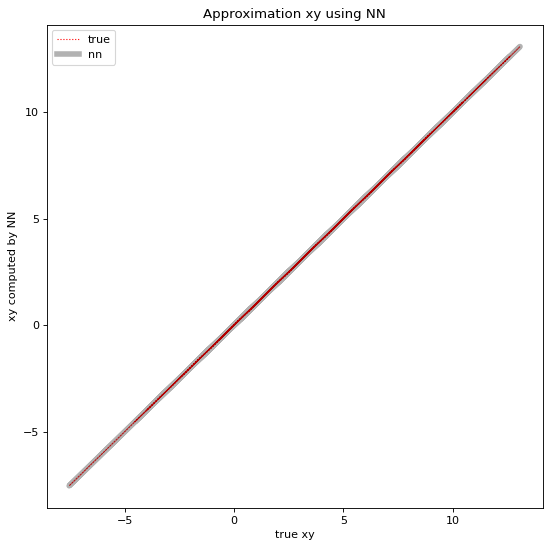

In [9]:
f, axes = plt.subplots(1,1, figsize=(8, 8), dpi=80, facecolor='w', edgecolor='k')

def plot_p_nn(net):
    xs, xys = create_data(50)
    nn_ys = net(xs).data.numpy()
    axes.plot(xys.numpy().squeeze(), xys.numpy().squeeze(), ':', label='true', color='r', linewidth=1)
    axes.plot(xys.numpy().squeeze(), nn_ys, color='k', label='nn', linewidth=5, alpha=0.3)
    axes.legend()
    
plot_p_nn(net)
axes.set_title('Approximation xy using NN')
axes.set_xlabel("true xy")
axes.set_ylabel("xy computed by NN")


plt.show()

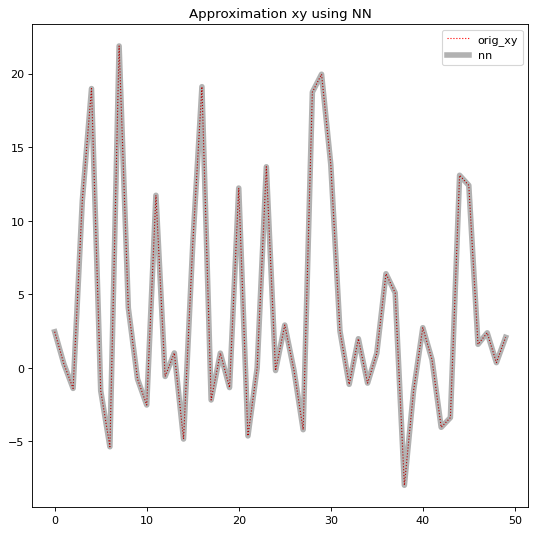

In [10]:
f, axes = plt.subplots(1,1, figsize=(8, 8), dpi=80, facecolor='w', edgecolor='k')

def plot_p_nn(net):
    xs, xys = create_data(50)
    nn_ys = net(xs).data.numpy()
    axes.plot(xys.numpy().squeeze(), ':', label='orig_xy', color='r', linewidth=1)
    axes.plot(nn_ys, color='k', label='nn',linewidth=5, alpha=0.3)
    axes.legend()
    
plot_p_nn(net)
axes.set_title('Approximation xy using NN')


plt.show()

# error dependency on $\epsilon$

number of h compositions 0
loss  tensor(167.1533660889)
number of h compositions 2
loss  tensor(0.4984423220)
number of h compositions 4
loss  tensor(0.0019065229)
number of h compositions 6
loss  tensor(7.5189700510e-06)
number of h compositions 9
loss  tensor(1.8331697271e-09)
number of h compositions 11
loss  tensor(1.1060601220e-11)
number of h compositions 13
loss  tensor(4.7906964853e-12)
number of h compositions 16
loss  tensor(4.8050179287e-12)
number of h compositions 18
loss  tensor(4.8051697170e-12)
number of h compositions 20
loss  tensor(4.8051692833e-12)


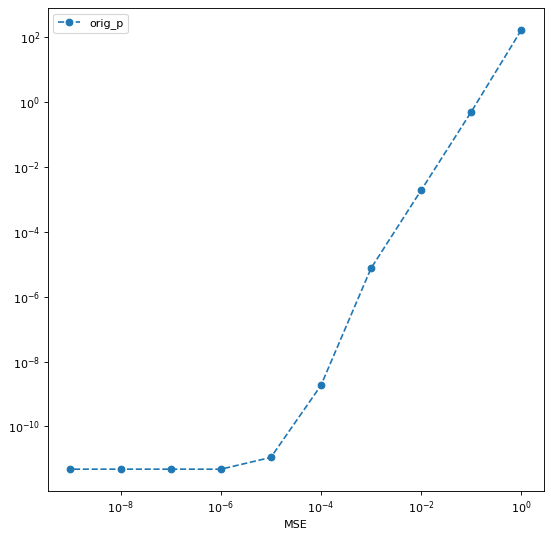

In [11]:
f, axes = plt.subplots(1,1, figsize=(8, 8), dpi=80, facecolor='w', edgecolor='k')
test_xs, test_ys = create_data(10000)
epsilons = [0.1**i for i in range(10)]
losses = []

for eps in epsilons:
    net = Net_xy(n, 1, eps, a=first, b=last)
    net.eval()
    output = net(test_xs)
    loss = criterion(output, test_ys).data
    print("loss ", loss)
    losses += [loss]

axes.plot(epsilons, losses, '--', label='orig_p', marker='o')
axes.set_yscale("log")
axes.set_xscale("log")
axes.set_xlabel("epsilon")
axes.set_xlabel("MSE")
axes.legend()
